<a href="https://colab.research.google.com/github/ElizaFuLan/Hiddden_Trigger/blob/main/Colab_GUAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Demo code for ICDM 2020 paper: **Generalizing Universal Adversarial Attacks beyond Additive Perturbations**

Below implements the GUAP universal attack for VGG19 on CIFAR-10 dataset.

You can execute each code block in turn to reproduce the experimental results on the colab.


In [ ]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA L4'

In [ ]:
assert torch.cuda.is_available()

In [ ]:
from google.colab import files
!wget -O cifar10_vgg19.pth https://www.dropbox.com/sh/gp66fuzw7uq2s4y/AAD9qzOKds8VYd3K35ahjvLAa/cifar10_vgg19.pth?dl=0

--2024-09-25 23:51:21--  https://www.dropbox.com/sh/gp66fuzw7uq2s4y/AAD9qzOKds8VYd3K35ahjvLAa/cifar10_vgg19.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/6nvti15cuy096ohrttiug/ABS3SXT_hDmLFoBEAf-dIQ0/cifar10_vgg19.pth?rlkey=dkaglisjeeo5d7t62u25qcw11&dl=0 [following]
--2024-09-25 23:51:21--  https://www.dropbox.com/scl/fo/6nvti15cuy096ohrttiug/ABS3SXT_hDmLFoBEAf-dIQ0/cifar10_vgg19.pth?rlkey=dkaglisjeeo5d7t62u25qcw11&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc58efb055d37f6d2be37938fc2d.dl.dropboxusercontent.com/cd/0/inline/CbRVx0sPSrEkPWtQsKs-5Et8JagaROV932pnMhD5GT_LNdajQx-CMiD56JgOTRMFNN8pXTdci9iEPBySwKRNMAYKsbKVZrC23BUUkL52bXAImgiKoWotlYovjJOZeChRau4SAb_J341LbUEgO25zGK2V/file# [foll

In [ ]:
'''Some helper functions for PyTorch
'''
import os
import sys
import time
import math
import numpy as np
import cv2
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import argparse
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
import logging
import time
import datetime
import random
import torchvision.models as models


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0.1)



def flow_st(images, flows,batch_size):

    # print(images.shape)
    H,W = images.size()[2:]


    # basic grid: tensor with shape (2, H, W) with value indicating the
    # pixel shift in the x-axis or y-axis dimension with respect to the
    # original images for the pixel (2, H, W) in the output images,
    # before applying the flow transforms
    grid_single = torch.stack(
                torch.meshgrid(torch.arange(0,H), torch.arange(0,W))
            ).float()


    grid = grid_single.repeat(batch_size, 1, 1, 1)#100,2,28,28

    images = images.permute(0,2,3,1) #100, 28,28,1

    grid = grid.cuda()


    grid_new = grid + flows
    # assert 0

    sampling_grid_x = torch.clamp(
        grid_new[:, 1], 0., (W - 1.)
            )
    sampling_grid_y = torch.clamp(
        grid_new[:, 0], 0., (H - 1.)
    )

    # now we need to interpolate

    # grab 4 nearest corner points for each (x_i, y_i)
    # i.e. we need a square around the point of interest
    x0 = torch.floor(sampling_grid_x).long()
    x1 = x0 + 1
    y0 = torch.floor(sampling_grid_y).long()
    y1 = y0 + 1

    # clip to range [0, H/W] to not violate image boundaries
    # - 2 for x0 and y0 helps avoiding black borders
    # (forces to interpolate between different points)
    x0 = torch.clamp(x0, 0, W - 2)
    x1 = torch.clamp(x1, 0, W - 1)
    y0 = torch.clamp(y0, 0, H - 2)
    y1 = torch.clamp(y1, 0, H - 1)


    b =torch.arange(0, batch_size).view(batch_size, 1, 1).repeat(1, H, W).cuda()



    # assert 0
    Ia = images[b, y0, x0].float()
    Ib = images[b, y1, x0].float()
    Ic = images[b, y0, x1].float()
    Id = images[b, y1, x1].float()


    x0 = x0.float()
    x1 = x1.float()
    y0 = y0.float()
    y1 = y1.float()

    wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
    wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
    wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
    wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)

    # add dimension for addition
    wa = wa.unsqueeze(3)
    wb = wb.unsqueeze(3)
    wc = wc.unsqueeze(3)
    wd = wd.unsqueeze(3)

    # compute output
    perturbed_image = wa * Ia+ wb * Ib+ wc * Ic+wd * Id


    perturbed_image = perturbed_image.permute(0,3,1,2)

    return perturbed_image


class Loss_flow(nn.Module):
    def __init__(self, neighbours=np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])):
        super(Loss_flow, self).__init__()

    def forward(self, flows):


        paddings = (1, 1, 1, 1,0, 0, 0, 0)
        padded_flows = F.pad(flows,paddings, "constant", 0)


        # #rook
        shifted_flowsr = torch.stack([
                    padded_flows[:, :, 2:, 1:-1],  # bottom mid
                    padded_flows[:, :, 1:-1, :-2],  # mid left
                    padded_flows[:, :, :-2, 1:-1],   # top mid
                    padded_flows[:, :, 1:-1, 2:],  # mid right
                    ],-1)


        flowsr = flows.unsqueeze(-1).repeat(1,1,1,1,4)
        _,h,w,_ = flowsr[:,0].shape


        loss0 = torch.norm((flowsr[:,0] - shifted_flowsr[:,0]).view(-1,4), p = 2, dim=(0), keepdim=True) ** 2
        loss1 = torch.norm((flowsr[:,1] - shifted_flowsr[:,1]).view(-1,4), p = 2, dim=(0), keepdim=True) ** 2

        return torch.max(torch.sqrt((loss0+loss1)/(h*w)))

def cal_l2dist(X1,X2):
    list_bhat = []
    list_hdist = []
    list_ssim = []
    list_l2 = []
    batch,nc,_,_ = X1.shape

    for i in range (batch):
        img1 = X1[i].unsqueeze(0)
        img2 = X2[i].unsqueeze(0)
        x1 = img1.mul(255).clamp(0, 255).permute(0,2,3,1).to('cpu', torch.uint8).numpy()
        x2 = img2.mul(255).clamp(0, 255).permute(0,2,3,1).to('cpu', torch.uint8).numpy()
        list_l2.append(np.sqrt(np.sum( (x1 - x2)**2 )))
    return np.mean(list_l2)






In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 h):
        super(Generator, self).__init__()

        encoder_lis = [
            # MNIST:1*28*28
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, image_nc, kernel_size=(6-h%2), stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 28 x 28
        ]
        decoder_lis2 = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, 2, kernel_size=(6-h%2), stride=1, padding=0, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. image_nc x 28 x 28
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)
        self.decoder2 = nn.Sequential(*decoder_lis2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x1 = self.decoder(x)
        x2 = self.decoder2(x)
        return x2,x1


In [ ]:
'''VGG11/13/16/19 in Pytorch.'''



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


# def test():
#     net = VGG('VGG11')
#     x = torch.randn(2,3,32,32)
#     y = net(x)
#     print(y.size())

# test()

In [ ]:
if not os.path.exists('log'):
    os.mkdir('log')

logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
    # filename='log/'+str(dataSet)+datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')+'.log')
logging.getLogger('matplotlib.font_manager').disabled = True


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='CIFAR10', help='CIFAR10')
parser.add_argument('--lr', type=float, required=False, default=0.01, help='Learning rate')
parser.add_argument('--batch-size', default=100, type=int)
parser.add_argument('--epochs', type=int, default=20, help='number of epochs to train for')
parser.add_argument('--savefig', type=int, default=1, help='save images')
parser.add_argument('--l2reg', type=float, default=0.0001, help='weight factor for l2 regularization')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--skip',  type=int, default=0, help='skip wrong classification')
parser.add_argument('--tau',  type=float, default=0.1, help='max flow magnitude, default=0.1')
parser.add_argument('--allow', type=float, default=0.03, help='allow for linf noise. default=0.03')
parser.add_argument('--model', type=str, default='VGG19', help='VGG19/ResNet101/DenseNet121')
parser.add_argument('--manualSeed', type=int, default=5198, help='manual seed')

# parser.add_argument('--cuda', action='store_true', help='enables cuda')
args = parser.parse_args(args=[])
logger.info(args)
tau = args.tau
lr = args.lr
dataSet = args.dataset
batch_size = args.batch_size
allow = args.allow
model_name = args.model
epochs = args.epochs
# 'DenseNet121','VGG19','ResNet101'



random.seed(args.manualSeed)
np.random.seed(args.manualSeed)
torch.manual_seed(args.manualSeed)
torch.cuda.manual_seed(args.manualSeed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
print('Generalizing Universarial Adversarial Examples')
print('==> Preparing data..')


torch.manual_seed(args.manualSeed)
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./cifar-data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar-data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)



nc,H,W = trainset.__getitem__(0)[0].shape

if model_name == 'VGG19':
    model = VGG('VGG19')
    model.load_state_dict(torch.load('cifar10_vgg19.pth')['net'])


dataset_mean = [0.4914, 0.4822, 0.4465]
dataset_std = [0.2023, 0.1994, 0.2010]
print(dataset_mean,dataset_std)

mu = torch.Tensor((dataset_mean)).unsqueeze(-1).unsqueeze(-1).cuda()
std = torch.Tensor((dataset_std)).unsqueeze(-1).unsqueeze(-1).cuda()
unnormalize = lambda x: x*std + mu
normalize = lambda x: (x-mu)/std


Generalizing Universarial Adversarial Examples
==> Preparing data..


100%|██████████| 170498071/170498071 [00:13<00:00, 12905655.13it/s]


Extracting ./cifar-data/cifar-10-python.tar.gz to ./cifar-data
Files already downloaded and verified


<ipython-input-8-108be9d5489a>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cifar10_vgg19.pth')['net'])


[0.4914, 0.4822, 0.4465] [0.2023, 0.1994, 0.201]


In [ ]:

for params in model.parameters():
    params.requires_grad = False
model.eval()

netAttacker = Generator(1,nc,H)
netAttacker.apply(weights_init)

model = model.cuda()
netAttacker = netAttacker.cuda()

noise = torch.FloatTensor(1, 1, H, W)
noise = noise.cuda()
noise = Variable(noise)
torch.nn.init.normal_(noise, mean=0, std=1.)

loss_flow = Loss_flow()


optimizer = torch.optim.Adam(netAttacker.parameters(), lr=lr, betas=(args.beta1, 0.999), weight_decay=args.l2reg)
print(noise)

tensor([[[[ 2.2867, -0.3514,  0.6537,  ...,  0.3269,  0.9311, -0.2144],
          [ 1.2197,  0.0430, -0.8319,  ...,  0.2018, -1.0325, -0.3502],
          [-0.1550, -0.0911, -0.4046,  ...,  2.5611,  0.4193,  1.3338],
          ...,
          [-1.5382, -0.5169, -0.3387,  ..., -1.2805,  1.1167, -1.1975],
          [ 0.3942, -1.5950,  0.7717,  ..., -0.4995, -1.4600, -1.3304],
          [ 0.8569,  0.0390,  0.3143,  ...,  0.2762, -0.8167, -2.2107]]]],
       device='cuda:0')


In [ ]:
bestatt = 0.
bestloss = 10000

logger.info('Epoch \t Time \t Tr_loss \t L \t Tr_acc \t Tr_stAtt \t Tr_noiseAtt \t Tr_Attack Rate ')

for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    train_attack_rate = 0
    train_st_rate = 0
    train_noise_rate = 0
    train_ori_acc = 0
    skipped = 0
    no_skipped = 0

    netAttacker.train()
    model.eval()

    for i, (X, y) in enumerate(train_loader):

        X, y = X.cuda(), y.cuda()
        batch_size = X.size(0)


        optimizer.zero_grad()

        train_ori_logits = model(X) # .detach() for LBFGS



        if args.skip:
            # get indexes where the original predictions are incorrect
            incorrect_idxs = np.array( np.where(train_ori_logits.data.max(1)[1].eq(y).cpu().numpy() == 0))[0].astype(int)
            skipped += incorrect_idxs.shape[0]
            no_skipped += (batch_size - incorrect_idxs.shape[0])
            if incorrect_idxs.shape[0] == batch_size:
                # print("All original predictions were incorrect! Skipping batch!")
                continue
            elif incorrect_idxs.shape[0] > 0 and incorrect_idxs.shape[0] < batch_size:
                # get indexes of the correct predictions and filter out the incorrect indexes
                correct_idxs = np.setdiff1d( np.arange(batch_size), incorrect_idxs)
                correct_idxs = torch.LongTensor(correct_idxs)
                correct_idxs = correct_idxs.cuda()
                X = torch.index_select(X, 0, Variable(correct_idxs))
                train_ori_logits = torch.index_select(train_ori_logits, 0, Variable(correct_idxs))
                y = torch.index_select(y, 0, correct_idxs)



        flow_field,perb_noise = netAttacker(noise)

        L = loss_flow(flow_field)


        flow_field = flow_field *args.tau/L
        perb_noise = perb_noise* allow


        batch_size = X.size(0)
        X_st = flow_st(unnormalize(X),flow_field,batch_size)


        X_noise = unnormalize(X)+ perb_noise
        X_noise = normalize(torch.clamp(X_noise, 0, 1))


        X_adv = X_st +perb_noise
        X_adv = normalize(torch.clamp(X_adv, 0, 1))

        optimizer.zero_grad()

        logits_st = model(normalize(X_st))
        logits_noise = model(X_noise)
        logits_adv = model(X_adv)



        adv_lossall = F.cross_entropy(logits_adv, train_ori_logits.max(1)[1], reduction = 'none')+1
        adv_loss = -torch.mean(torch.log(adv_lossall))


        adv_loss.backward()
        optimizer.step()



        train_ori_acc += (train_ori_logits.max(1)[1] == y).sum().item()
        train_loss += adv_loss.item() * y.size(0)
        train_attack_rate += ((logits_adv.max(1)[1] != train_ori_logits.max(1)[1])).sum().item()
        train_st_rate += ((logits_st.max(1)[1] != train_ori_logits.max(1)[1])).sum().item()
        train_noise_rate += ((logits_noise.max(1)[1] != train_ori_logits.max(1)[1])).sum().item()


        train_n += y.size(0)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f',
                epoch, train_time - start_time, train_loss / train_n, L.data.cpu(), train_ori_acc/(train_n+skipped),train_st_rate/train_n,train_noise_rate/train_n, train_attack_rate/train_n)



    if bestatt<train_attack_rate/train_n and bestloss>train_loss / train_n:
        bestloss = train_loss / train_n
        bestatt = train_attack_rate/train_n
        bestflow = flow_field
        bestnoise = perb_noise

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print('Best train ASR:',end = '\t')
print(bestatt)
flow_field = bestflow
perb_noise = bestnoise

print('==> start testing ..')
test_ori_acc = 0
test_n = 0
test_adv_loss = 0
test_adv_acc = 0
test_attack_rate = 0
test_st_rate = 0
test_noise_rate = 0

start_time = time.time()

clean_np = np.empty((0,nc, H, W))
st_np = np.empty((0,nc, H, W))
perb_np = np.empty((0, nc, H, W))
clean_preds_np = np.empty(0)
perb_preds_np = np.empty(0)
skipped = 0
no_skipped = 0
model.eval()
netAttacker.eval()

test_l2 = []
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        X, y = X.cuda(), y.cuda()

        batch_size = X.size(0)
        test_ori_logits = model(X)

        if args.skip:
            # get indexes where the original predictions are incorrect
            incorrect_idxs = np.array( np.where(test_ori_logits.data.max(1)[1].eq(y).cpu().numpy() == 0))[0].astype(int)
            skipped += incorrect_idxs.shape[0]
            no_skipped += (batch_size - incorrect_idxs.shape[0])
            if incorrect_idxs.shape[0] == batch_size:
                #print("All original predictions were incorrect! Skipping batch!")
                continue
            elif incorrect_idxs.shape[0] > 0 and incorrect_idxs.shape[0] < batch_size:
                # get indexes of the correct predictions and filter out the incorrect indexes
                correct_idxs = np.setdiff1d( np.arange(batch_size), incorrect_idxs)
                correct_idxs = torch.LongTensor(correct_idxs)
                correct_idxs = correct_idxs.cuda()
                X = torch.index_select(X, 0, Variable(correct_idxs))
                test_ori_logits = torch.index_select(test_ori_logits, 0, Variable(correct_idxs))
                y = torch.index_select(y, 0, correct_idxs)

        batch_size = X.size(0)

        X_st = flow_st(unnormalize(X),flow_field,batch_size)



        X_noise = unnormalize(X)+ perb_noise
        X_noise = normalize(torch.clamp(X_noise, 0, 1))



        X_perb = X_st+ perb_noise
        X_perb = normalize(torch.clamp(X_perb, 0, 1))


        X_st = normalize(X_st)

        test_logits_st = model(X_st)
        test_logits_noise = model(X_noise)
        test_logits_adv = model(X_perb)


        test_ori_acc += (test_logits_adv.max(1)[1] == y).sum().item()


        adv_lossall = F.cross_entropy(test_logits_adv, test_ori_logits.max(1)[1], reduction = 'none')+1
        adv_loss = -torch.mean(torch.log(adv_lossall))

        test_adv_loss += adv_loss.item() * y.size(0)

        success_bool = (test_logits_adv.max(1)[1] != test_ori_logits.max(1)[1])
        test_attack_rate += success_bool.sum().item()
        test_st_rate += ((test_logits_st.max(1)[1] != test_ori_logits.max(1)[1])).sum().item()
        test_noise_rate += ((test_logits_noise.max(1)[1] != test_ori_logits.max(1)[1])).sum().item()

        if len(clean_preds_np)<10:
            clean_np = np.append(clean_np, X[success_bool].data.cpu(),axis=0)
            st_np = np.append(st_np, X_st[success_bool].data.cpu(),axis=0)
            perb_np = np.append(perb_np, X_perb[success_bool].data.cpu(),axis=0)
            clean_preds_np = np.append(clean_preds_np, test_ori_logits.max(1)[1][success_bool].data.cpu())
            perb_preds_np = np.append(perb_preds_np,test_logits_adv.max(1)[1][success_bool].data.cpu())


        test_n += y.size(0)
        l2dist = cal_l2dist(unnormalize(X),unnormalize(X_perb))
        test_l2.append(l2dist)


test_time = time.time()
test_l2 = [x for x in test_l2 if str(x)!='nan']



logger.info('Perb Test Acc \t L2 \t Time \t Adv Test_loss \t Te_stAtt \t Te_noiseAtt\t Te_Attack Rate ')
logger.info('%.4f \t %.4f \t %.2f \t %.4f \t %.4f \t %.4f \t %.4f', test_ori_acc/(test_n+skipped),np.mean(test_l2),test_time - start_time, test_adv_loss/test_n, test_st_rate/test_n,test_noise_rate/test_n, test_attack_rate/test_n)


Best train ASR:	0.87854
==> start testing ..


In [ ]:
def norm_ip(img):
    min = float(img.min())
    max = float(img.max())
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)
    return img


clean = unnormalize(torch.from_numpy(clean_np[:10]).cuda()).cpu().clamp(0,1)
st = unnormalize(torch.from_numpy(st_np[:10]).cuda()).cpu().clamp(0,1)
adv = unnormalize(torch.from_numpy(perb_np[:10]).cuda()).cpu().clamp(0,1)

middlenoise1 = st - clean
middlenoise2 = adv - st
for i in range(10):
  middlenoise1[i] = norm_ip(middlenoise1[i])
  middlenoise2[i] = norm_ip(perb_noise.detach().unsqueeze(0).cpu())





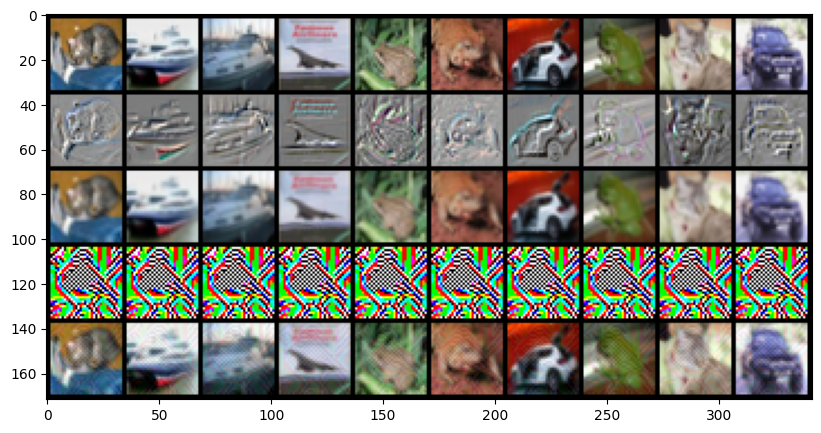

In [ ]:
fig = plt.figure(figsize=(10, 5))
grid = vutils.make_grid(torch.cat((clean,middlenoise1,st,middlenoise2,adv)).float(),nrow=10)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
# From top to bottom: original image -- perb by sp -- st image -- perb by noise -- adv image

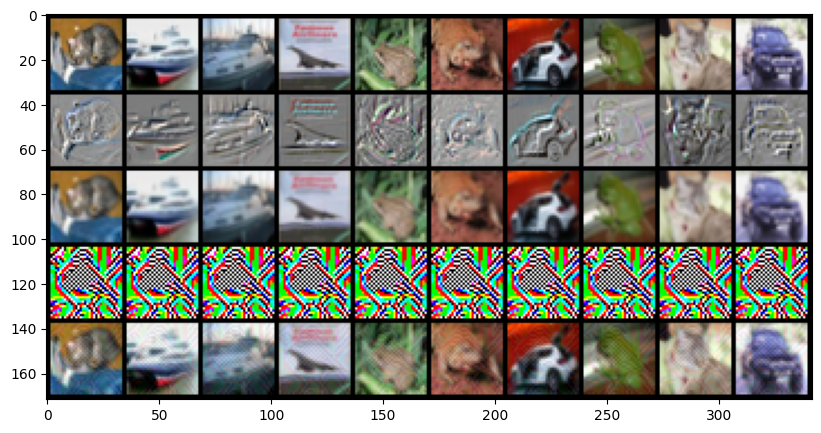

In [ ]:
#examples when tau = 0, eplison = 0.04
fig = plt.figure(figsize=(10, 5))
grid = vutils.make_grid(torch.cat((clean,middlenoise1,st,middlenoise2,adv)).float(),nrow=10)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

perb_noise 张量信息：
tensor([[[[-0.0261, -0.0282,  0.0300,  ...,  0.0298, -0.0281,  0.0002],
          [-0.0279,  0.0297,  0.0300,  ..., -0.0276,  0.0293,  0.0020],
          [ 0.0300,  0.0294, -0.0300,  ...,  0.0280, -0.0300, -0.0296],
          ...,
          [-0.0298, -0.0264,  0.0273,  ...,  0.0300, -0.0297,  0.0300],
          [ 0.0296,  0.0293,  0.0285,  ...,  0.0300,  0.0300, -0.0296],
          [ 0.0298,  0.0294,  0.0283,  ..., -0.0287,  0.0298, -0.0256]],

         [[ 0.0268,  0.0300,  0.0299,  ..., -0.0299, -0.0300,  0.0221],
          [ 0.0291,  0.0298, -0.0300,  ..., -0.0300,  0.0300,  0.0289],
          [ 0.0298, -0.0297, -0.0300,  ...,  0.0287, -0.0296, -0.0300],
          ...,
          [-0.0291,  0.0297, -0.0256,  ...,  0.0298, -0.0300,  0.0299],
          [ 0.0178, -0.0283, -0.0293,  ...,  0.0284, -0.0293, -0.0297],
          [-0.0288, -0.0254,  0.0272,  ..., -0.0300,  0.0300, -0.0267]],

         [[-0.0265, -0.0279, -0.0151,  ..., -0.0289, -0.0300, -0.0213],
          [-0

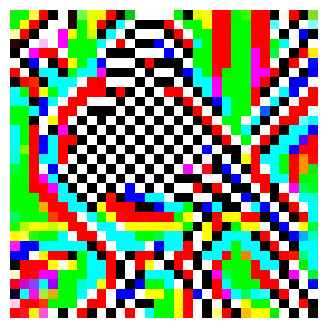

In [ ]:
print('perb_noise 张量信息：')
print(perb_noise)
print(perb_noise.shape)

import matplotlib.pyplot as plt

# 去掉批次维度，选择第一个样本
perb_noise_sample = perb_noise_normalized[0]  # 去掉 batch 维度，结果形状为 [3, 32, 32]

# 将张量从计算图中分离出来并转换为 NumPy 格式
perb_noise_np = perb_noise_sample.detach().cpu().numpy().transpose(1, 2, 0)

# 可视化 perb_noise
plt.figure(figsize=(4, 4))
plt.imshow(perb_noise_np)
plt.axis('off')
plt.show()

图片已保存至: /content/uap_noise_visualization.png


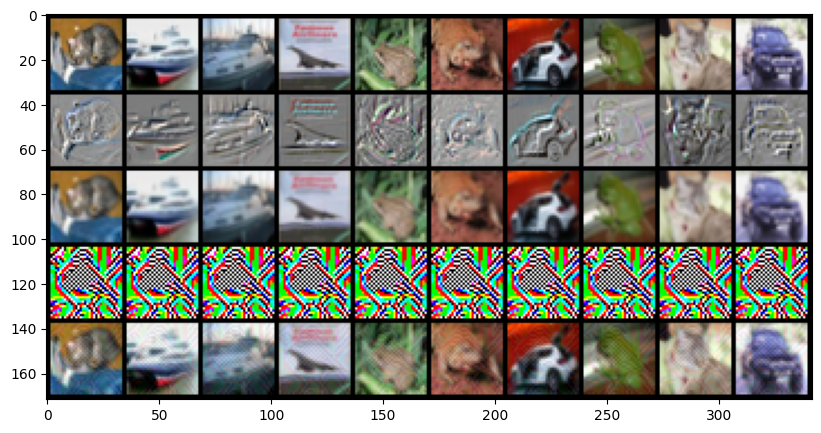

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# 可视化并保存 UAP 噪声图像
fig = plt.figure(figsize=(10, 5))
grid = vutils.make_grid(torch.cat((clean, middlenoise1, st, middlenoise2, adv)).float(), nrow=10)

# 显示并保存图像
plt.imshow(grid.numpy().transpose((1, 2, 0)))

# 指定文件名并保存图像
filename = 'uap_noise_visualization.png'
plt.savefig(filename, bbox_inches='tight')

# 关闭图像显示以释放内存
# plt.close(fig)

# 获取保存图片的完整路径
save_path = os.path.abspath(filename)

# 输出保存路径
print(f'图片已保存至: {save_path}')


uap noise(original): tensor([[[6.4890e-02, 2.9519e-02, 9.9937e-01,  ..., 9.9716e-01,
          3.1704e-02, 5.0393e-01],
         [3.4845e-02, 9.9538e-01, 9.9965e-01,  ..., 4.0530e-02,
          9.8891e-01, 5.3405e-01],
         [9.9974e-01, 9.8914e-01, 3.7247e-07,  ..., 9.6691e-01,
          3.6263e-04, 6.9861e-03],
         ...,
         [3.0474e-03, 5.9684e-02, 9.5525e-01,  ..., 9.9973e-01,
          4.8336e-03, 9.9910e-01],
         [9.9333e-01, 9.8894e-01, 9.7508e-01,  ..., 9.9983e-01,
          9.9950e-01, 5.9219e-03],
         [9.9586e-01, 9.8901e-01, 9.7209e-01,  ..., 2.1123e-02,
          9.9596e-01, 7.2918e-02]],

        [[9.4669e-01, 9.9960e-01, 9.9793e-01,  ..., 8.6201e-04,
          3.3479e-04, 8.6833e-01],
         [9.8422e-01, 9.9646e-01, 2.9859e-05,  ..., 5.9595e-06,
          9.9918e-01, 9.8193e-01],
         [9.9582e-01, 5.2320e-03, 3.7064e-04,  ..., 9.7840e-01,
          6.9059e-03, 5.4923e-04],
         ...,
         [1.5160e-02, 9.9439e-01, 7.2955e-02,  ..., 9.9683

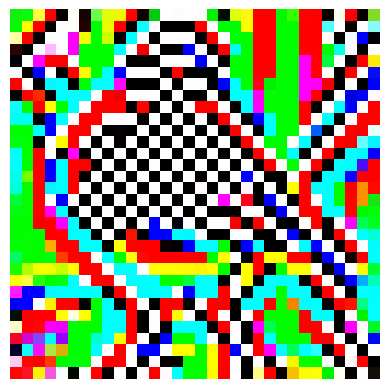

In [ ]:
import matplotlib.pyplot as plt
import os

# 假设你想保存第四行的第一张 UAP 噪声图片
uap_noise_image = middlenoise2[0]  # 选择第四行中的第一张图片

# 将张量转换为 NumPy 格式，并进行转置以符合图像显示格式
uap_noise_image_np = uap_noise_image.numpy().transpose((1, 2, 0))

# 可视化并保存 UAP 噪声图片
# fig = plt.figure(figsize=(1, 1), dpi=32)  # 设置图像大小为 32x32 像素
print("uap noise(original):", uap_noise_image)
print("uap noise(shaped to numpy):", uap_noise_image_np)
plt.imshow(uap_noise_image_np)
plt.axis('off')  # 关闭坐标轴

# 指定文件名并保存单张 UAP 噪声图像
# filename = 'single_uap_noise_32x32.png'
filename = 'single_uap_noise_.png'
plt.savefig(filename, bbox_inches='tight', pad_inches=0)

# 关闭图像显示以释放内存
# plt.close(fig)

# 获取保存图片的完整路径
save_path = os.path.abspath(filename)

# 输出保存路径
print(f'UAP 噪声图片已保存至: {save_path}')

In [ ]:
import matplotlib.pyplot as plt
import os

# 假设你想保存第四行的第一张 UAP 噪声图片
uap_noise_image = middlenoise2[0]  # 选择第四行中的第一张图片

# 将张量转换为 NumPy 格式，并进行转置以符合图像显示格式
uap_noise_image_np = uap_noise_image.numpy().transpose((1, 2, 0))

# 可视化并保存 UAP 噪声图片
fig = plt.figure(figsize=(1, 1), dpi=32)  # 设置图像大小为 32x32 像素
plt.imshow(uap_noise_image_np)
plt.axis('off')  # 关闭坐标轴

# 指定文件名并保存单张 UAP 噪声图像
filename = 'single_uap_noise_32x32.png'
plt.savefig(filename, bbox_inches='tight', pad_inches=0)

# 关闭图像显示以释放内存
# plt.close(fig)

# 获取保存图片的完整路径
save_path = os.path.abspath(filename)

# 输出保存路径
print(f'UAP 噪声图片已保存至: {save_path}')


In [ ]:
import torchvision.utils as vutils

# 确保已经得到了最佳的perb_noise (bestnoise)
# 这应该在训练循环中已经更新

# 将UAP(perb_noise)保存为JPEG
print("uap tensor:", bestnoise)
vutils.save_image(bestnoise, 'uap.png', normalize=True)

# 创建一个放大版本以便更好地可视化
scaled_noise = bestnoise * 10  # 放大10倍
vutils.save_image(scaled_noise, 'uap_scaled.png', normalize=True)

print("UAP has been saved as 'uap.png' and 'uap_scaled.png'")

# 同时保存为pth文件以便后续使用
torch.save(bestnoise, 'uap.pth')
print("UAP has also been saved as 'uap.pth' for future use")

# 可选: 展示UAP效果
example_image = torch.randn(1, 3, 32, 32).cuda()  # 假设使用CIFAR10的32x32图像
perturbed_image = unnormalize(example_image) + bestnoise
perturbed_image = normalize(torch.clamp(perturbed_image, 0, 1))

combined_vis = vutils.make_grid([example_image.squeeze(), perturbed_image.squeeze()], normalize=True, scale_each=True)
plt.figure(figsize=(10, 5))
plt.imshow(combined_vis.permute(1, 2, 0).cpu().detach().numpy())
plt.title("Original vs Perturbed Image (UAP effect)")
plt.savefig('uap_effect_example.jpeg')
plt.close()

uap tensor: tensor([[[[-0.0261, -0.0282,  0.0300,  ...,  0.0298, -0.0281,  0.0002],
          [-0.0279,  0.0297,  0.0300,  ..., -0.0276,  0.0293,  0.0020],
          [ 0.0300,  0.0294, -0.0300,  ...,  0.0280, -0.0300, -0.0296],
          ...,
          [-0.0298, -0.0264,  0.0273,  ...,  0.0300, -0.0297,  0.0300],
          [ 0.0296,  0.0293,  0.0285,  ...,  0.0300,  0.0300, -0.0296],
          [ 0.0298,  0.0294,  0.0283,  ..., -0.0287,  0.0298, -0.0256]],

         [[ 0.0268,  0.0300,  0.0299,  ..., -0.0299, -0.0300,  0.0221],
          [ 0.0291,  0.0298, -0.0300,  ..., -0.0300,  0.0300,  0.0289],
          [ 0.0298, -0.0297, -0.0300,  ...,  0.0287, -0.0296, -0.0300],
          ...,
          [-0.0291,  0.0297, -0.0256,  ...,  0.0298, -0.0300,  0.0299],
          [ 0.0178, -0.0283, -0.0293,  ...,  0.0284, -0.0293, -0.0297],
          [-0.0288, -0.0254,  0.0272,  ..., -0.0300,  0.0300, -0.0267]],

         [[-0.0265, -0.0279, -0.0151,  ..., -0.0289, -0.0300, -0.0213],
          [-0.0300